# 1. Organising

File structure:

./   
| -- gene classification.ipynb  
| -- data/  
|$\;\;\;\;$| -- actual.csv  
|$\;\;\;\;$| -- data_set_ALL_AML_train.csv  
|$\;\;\;\;$| -- data_set_ALL_AML_independent.csv  

In [162]:
!ls ./data

actual.csv                       data_set_ALL_AML_train.csv
data_set_ALL_AML_independent.csv


# 2. Import libraries

In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy import stats
%matplotlib inline

# 3. Define Functions

In [164]:
def split(df):
    """
    Extacts columns containing categorical and non cantinious values.
    
    input:  df, a dataframe
    output: cont, a list of columns containing continious data
            cat, a list of columns containing categorical data
    """
    cat, cont = [], []
    for n in df:
        if df[n].dtypes == object: 
            cat.append(n)
        else: 
            cont.append(n)
    return cont, cat

In [165]:
def quantify_presence(df, categories):
    """
    Transforms categorical values into numerical values.
    
    input:  df, a dataframe
            categories, a list of columns containing categories
    output: df, a dataframe with numerical values
    """
    for category in categories:
        df.loc[:,category] = df.loc[:,category].astype('category').cat.as_ordered() # Categories (3, object): [A < M < P]
        df.loc[:,category] = df.loc[:,category].cat.rename_categories([0,0.51,1])   # Categories (3, float64): [0.00 < 0.51 < 1.00]

# 4. Importing The Data
- ___actual___ contains the results for the _train_ and the _test_ data together;
- ___independent___ contains the test variables;
- ___train___ contains the training variables.

In [166]:
actual = pd.read_csv('./data/actual.csv')
actual.groupby('cancer').count()
actual.shape

(72, 2)

In [167]:
test = pd.read_csv('./data/data_set_ALL_AML_independent.csv')
test.shape

(7129, 70)

In [168]:
train = pd.read_csv('./data/data_set_ALL_AML_train.csv')
train.shape

(7129, 78)

# 5. Preparing The Train Data

Obtain the train continious and categorical columns:

In [169]:
train_conts, train_cats = split(train)
train_cats = [x for x in train_cats if x not in ['Gene Description','Gene Accession Number']]

Show the names of the first four columns for each train continious and categorical columns:

In [170]:
print(train_conts[:4])
print(train_cats[:4])

['1', '2', '3', '4']
['call', 'call.1', 'call.2', 'call.3']


# 6. Preparing The Testing Dataframe

Obtain the test continious and categorical columns:

In [171]:
test_conts, test_cats = split(test)
test_cats = [x for x in test_cats if x not in ['Gene Description','Gene Accession Number']]

Show the names of the first four columns for each test continious and categorical columns:

In [172]:
print(test_conts[:4])
print(test_cats[:4])

['39', '40', '42', '47']
['call', 'call.1', 'call.2', 'call.3']


# 7. Building The Training Dataframe

Transpose the original train dataframe so the chromosoms become the column variables:

In [173]:
X = pd.concat([train.iloc[:,1], train[train_conts]], axis=1).T
X.columns = X.iloc[0]
X.drop(X.index[0], inplace=True)
X.index.name = None

Filter the results for the patients from the train data from the list of results for all patients:

In [174]:
Y = actual['cancer'].loc[actual['patient'].isin(X.index)]

Look at the shape of the train data and train results:

In [175]:
print(X.shape)
print(Y.shape)

(38, 7129)
(38,)


There are 38 patients, 7129 crhomosomes.

# 8. Build the test dataframe

Transpose the original test dataframe so the chromosoms become the column variables:

In [176]:
x = pd.concat([test.iloc[:,1], test[test_conts]], axis=1).T
x.columns = x.iloc[0]
x.drop(x.index[0], inplace=True)
x.index.name = None

Filter the results for the patients from the test data from the list of results for all patients:

In [177]:
y = actual['cancer'].loc[actual['patient'].isin(x.index)]

Look at the shape of the test data and train results:

In [178]:
print(x.shape)
print(y.shape)

(34, 7129)
(34,)


There are 34 patients, 7129 chromosomes.

# 9. Use ML to classify

Set variable to keep track of scores:

In [179]:
scores = {} # to store the scores for various tests
times = {} # to store the time statistic (mean and variation) it took to do the test

## 9.1 Using LinearSVM

In [180]:
from sklearn import svm

In [181]:
svm = svm.LinearSVC()
# fitting the classifier and timing it at the same time:
times['SVM time'] = %timeit -o svm.fit(X, Y)

188 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [182]:
svm.predict(x)

array(['ALL', 'ALL', 'ALL', 'AML', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL',
       'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL', 'ALL',
       'ALL', 'ALL', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML',
       'AML', 'AML', 'AML', 'AML', 'AML', 'AML', 'AML'], dtype=object)

In [183]:
svm_score = np.round(svm.score(x,y)*100,1)
scores['SVM'] = svm_score
print('SVM score: ', svm_score, '%')

SVM score:  55.9 %


## 9.2 Using Decision Tree Classifier

In [184]:
from sklearn.tree import DecisionTreeClassifier

In [185]:
dtc = DecisionTreeClassifier(random_state=0)

In [186]:
dtc = dtc.fit(X, Y)

In [187]:
# timing it
times['Decision Tree'] = %timeit -o dtc.fit(X, Y)

75.8 ms ± 2.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [188]:
dtc_score = np.round(dtc.score(x, y)*100,1)
scores['Decision Tree'] = dtc_score
print('Decision Tree score: ', dtc_score, '%')

Decision Tree score:  61.8 %


## 9.3 Using Random Forest Classifier

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

In [190]:
stratified_scores = []
scores_rfc = []
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)

# Test for 1 to 200 random forests:
for i in range(1,200,10):
    rfc = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=2, random_state=0)
    rfc = rfc.fit(X, Y)
    stratified_scores.append(cross_val_score(rfc, X, Y, cv=sss).mean())
    scores_rfc.append(rfc.score(x, y))

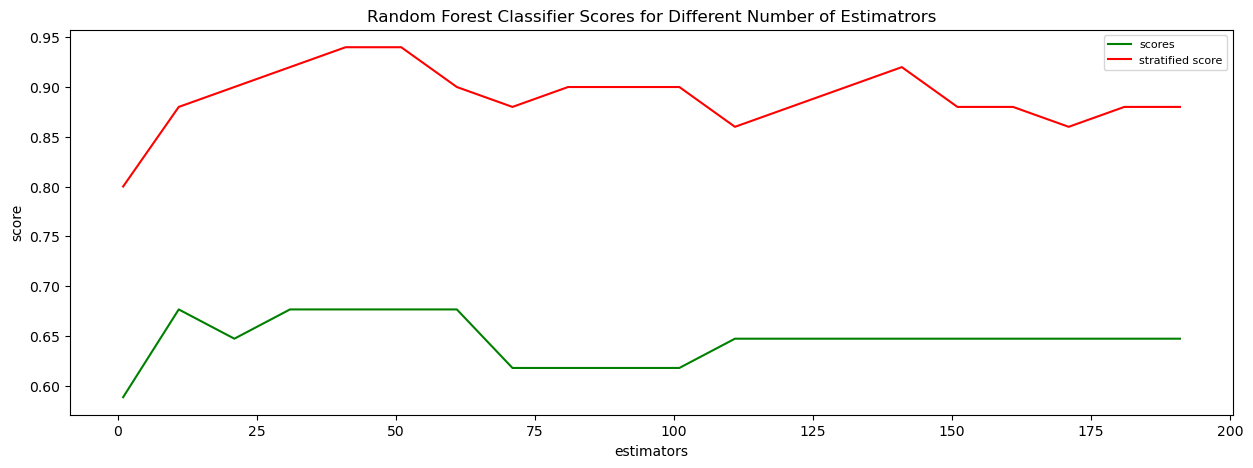

In [191]:
labels = ['scores','stratified scores']
plt.figure(figsize=(15,5))
plt.plot(range(1,200,10), scores_rfc, color='g', label='scores')
plt.plot(range(1,200,10), stratified_scores, color='r', label='stratified score')
plt.title('Random Forest Classifier Scores for Different Number of Estimatrors')
plt.xlabel('estimators')
plt.ylabel('score')
plt.gca().axes.legend(loc='best',fontsize=8)

In [192]:
best_number_forests = range(1,200,10)[np.where(stratified_scores==max(stratified_scores))[0][0]]
rfc_score = np.round(max(scores_rfc)*100, 1)
scores['Random Forest'] = rfc_score
print('Random Forest score: ', rfc_score, '%')
print('Minimal number of forests to achieve maximum score: ', best_number_forests)

Random Forest score:  67.6 %
Minimal number of forests to achieve maximum score:  41


Timing the execution times:

In [193]:
rfc = RandomForestClassifier(n_estimators=best_number_forests, 
                             max_depth=None, min_samples_split=2, random_state=0)
times['Random Forest'] = %timeit -o rfc.fit(X, Y)

135 ms ± 7.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [194]:
# rfc.predict(x)==y

## 9.4 Using extra tree classifier

In [195]:
from sklearn.ensemble import ExtraTreesClassifier

In [196]:
scores_etc = []
for i in range(1,200,5):
    etc = ExtraTreesClassifier(n_estimators=i, max_depth=None, min_samples_split=2, random_state=0)
    etc = etc.fit(X, Y)
    scores_etc.append(etc.score(x, y))

Text(0, 0.5, 'score')

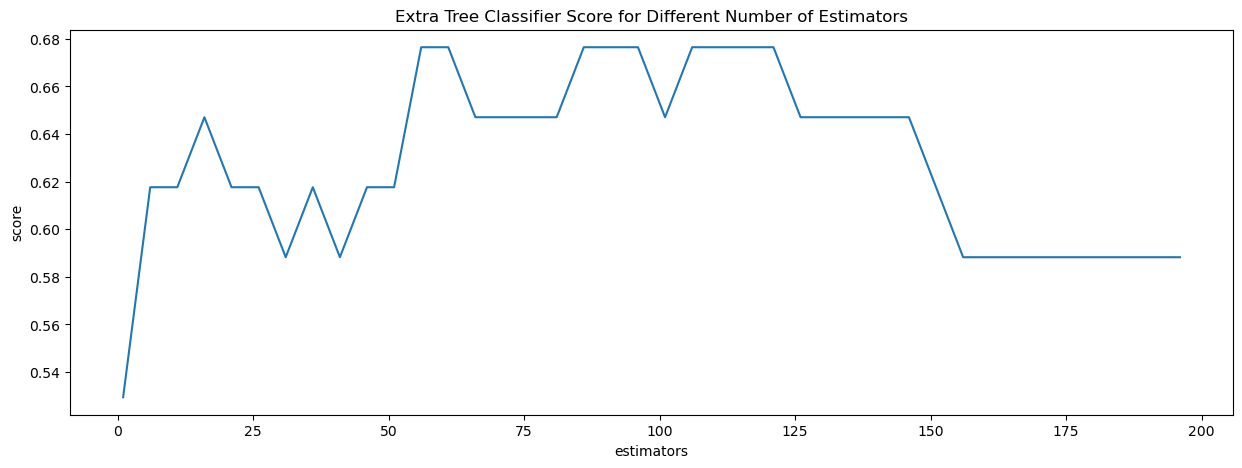

In [197]:
plt.figure(figsize=(15,5))
plt.plot(range(1,200,5), scores_etc)
plt.title('Extra Tree Classifier Score for Different Number of Estimators')
plt.xlabel('estimators')
plt.ylabel('score')

In [198]:
etc_score = np.round(max(scores_etc)*100,1)
scores['Extra Tree'] = etc_score
print('Extra Tree Classifier Score:', etc_score, '%')
beset_numb_trees = np.where(scores_etc == max(scores_etc))[0]
print('Attainable with', range(1,200,5)[beset_numb_trees[0]], 'trees.')

Extra Tree Classifier Score: 67.6 %
Attainable with 56 trees.


Timing the execution times:

In [199]:
etc = ExtraTreesClassifier(n_estimators=range(1,200,5)[beset_numb_trees[0]],
                           max_depth=None, min_samples_split=2, random_state=0)
times['Extra Tree'] = %timeit -o etc.fit(X, Y)

137 ms ± 5.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 9.5 Using AddaBoost

In [200]:
from sklearn.ensemble import AdaBoostClassifier

In [201]:
scores_adb = []
for i in range(1,200,10):
    adb = AdaBoostClassifier(n_estimators=i)
    adb = adb.fit(X,Y)
    scores_adb.append(adb.score(x,y))

In [202]:
#plt.plot(range(1,200,10),scores_adb)

In [203]:
adb_score =  np.round(max(scores_adb)*100,1)
scores['AddaBoost'] = adb_score
print('AddaBoost score:', adb_score,'%')

AddaBoost score: 61.8 %


In [204]:
# timing it:
adb = AdaBoostClassifier(n_estimators=2)
times['AddaBoost'] = %timeit -o adb.fit(X,Y)

99.9 ms ± 1.61 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 9.6 Using Logistic Regression

In [205]:
from sklearn.linear_model import LogisticRegression

In [206]:
scores_lr = []
interval = np.arange(0.1, 5, 0.05)
for i in interval:
    lr = LogisticRegression(C=i)
    lr = lr.fit(X,Y)
    scores_lr.append(lr.score(x,y))

Text(0, 0.5, 'score')

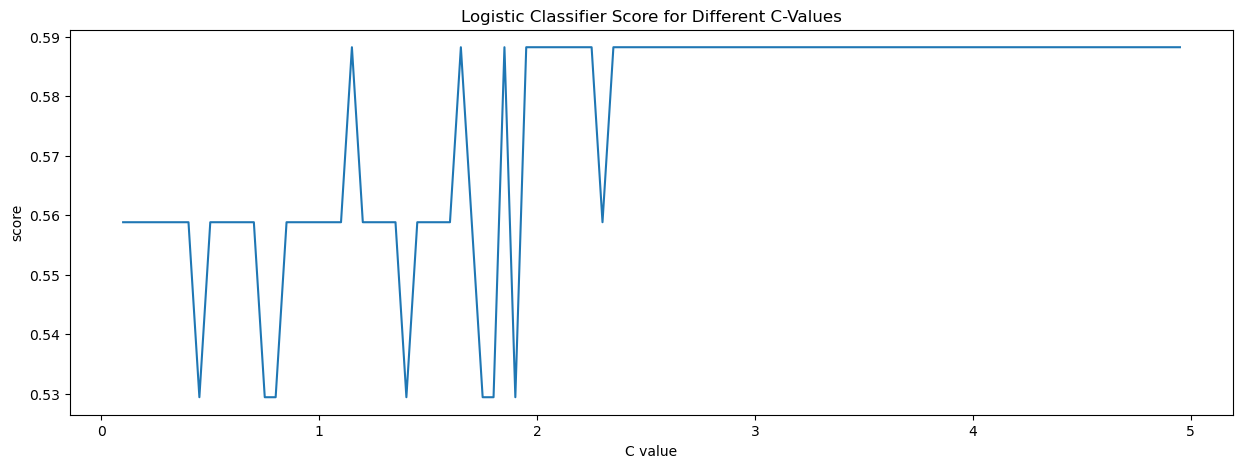

In [207]:
plt.figure(figsize=(15,5))
plt.plot(interval,scores_lr)
plt.title('Logistic Classifier Score for Different C-Values')
plt.xlabel('C value')
plt.ylabel('score')

In [208]:
lc_score = np.round(max(scores_lr)*100,1)
scores['Logistic'] = lc_score
print('Logistic classifier score:', lc_score,'%')

Logistic classifier score: 58.8 %


In [209]:
# timing it:
lr = LogisticRegression(C=2)
times['Logistic'] = %timeit -o lr.fit(X,Y)

220 ms ± 22.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 9.7 Usimg K-NN Classification

In [210]:
from sklearn.neighbors import KNeighborsClassifier

In [211]:
scores_knn = []
for i in range(2,20, 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(X, Y)
    scores_knn.append(knn.score(x,y))

Text(0, 0.5, 'score')

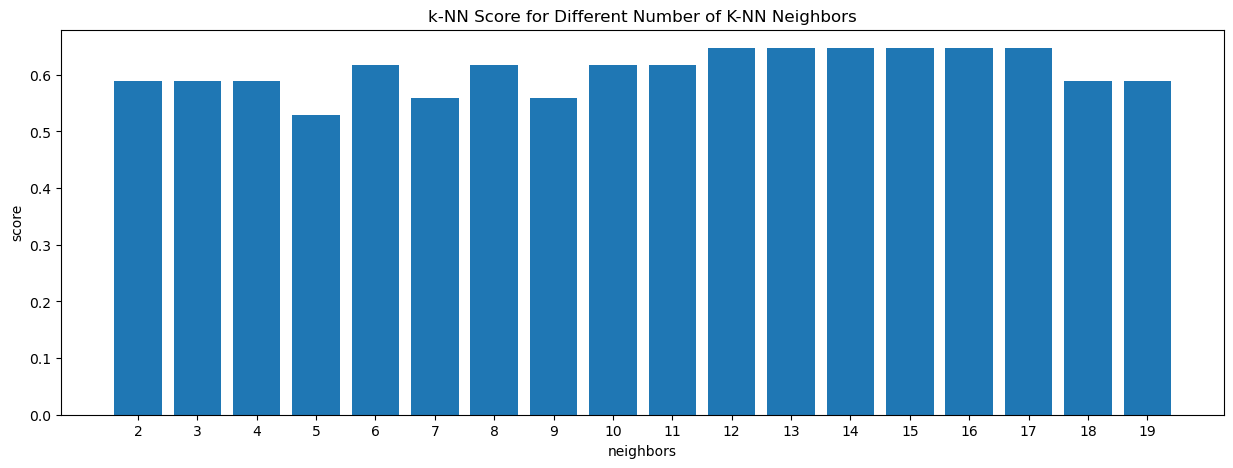

In [212]:
plt.figure(figsize=(15,5))
plt.bar(range(2,20,1), scores_knn)
plt.gca().axes.set_xticks(range(2,20,1))
plt.title('k-NN Score for Different Number of K-NN Neighbors')
plt.xlabel('neighbors')
plt.ylabel('score')

In [213]:
knn_score = np.round(max(scores_knn)*100,1)
scores['kNN'] = knn_score
print('kNN score:', knn_score,'%')
print('using',2+np.where(scores_knn==max(scores_knn))[0][0],'nearest neighbors')

kNN score: 64.7 %
using 12 nearest neighbors


Timing the execution times:

In [214]:
knn = KNeighborsClassifier(n_neighbors=(2 + np.where(scores_knn==max(scores_knn))[0][0]))
times['kNN'] = %timeit -o knn.fit(X, Y)

54.7 ms ± 1.67 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## 9.8 Usimg KMeans Clustering

In [215]:
from sklearn.cluster import KMeans

In [216]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X,Y)

In [217]:
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0], dtype=int32)

In [218]:
prediction = kmeans.predict(x)
prediction
len(prediction)

34

In [219]:
y_binary = np.array([1 if x=='ALL' else 0 for x in y], dtype=int)
y_binary
len(y_binary)

34

In [220]:
correct = 0
for pt in range(len(y_binary)):
    if y_binary[pt] == prediction[pt]:
        correct += 1
kmeans_accuracy = np.round(correct / float(len(y_binary)) * 100, 1)
print('KMeans Accuracy:', kmeans_accuracy,'%')
scores['KMeans'] = kmeans_accuracy

KMeans Accuracy: 55.9 %


In [221]:
# timing it:
times['KMeans'] = %timeit -o kmeans.fit(X,Y)

180 ms ± 27.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# 10. Usig technique developed by Golup et al. #
#### (1) Golub T. R., Slonim D. K., Tamayo P., et al. Molecular classification of cancer: class discovery and class prediction by gene expression monitoring. Science. 1999;286(5439):531–537. doi: 10.1126/science.286.5439.531 #####

Building an ideal gene in which ALL are all 1 and AML are all 0.

In [222]:
ideal_gene = np.ones(Y[Y=='ALL'].index.size).astype(int)
ideal_gene = np.append(ideal_gene, np.zeros(Y[Y=='AML'].index.size).astype(int))
ideal_gene = np.tile(ideal_gene, (7129,1)).T
ideal_gene = pd.DataFrame(ideal_gene)
ideal_gene

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


Normalise the test data, so it can be compared to the idealised gene, weith values in [0,1]:

In [223]:
X_normalized = (X-X.min())/(X.max()-X.min())

In [224]:
X_normalized.index = X_normalized.index.astype(int)

Reorder the indexes:

In [225]:
X_normalized.sort_index()
X_normalized.reset_index(inplace=True, drop=True)
X_normalized.columns = ideal_gene.columns
#X_normalized.index

Build a dataframe conaining the correlations between the normalised test data and the ideal gene:

In [226]:
df = ideal_gene.corrwith(X_normalized.astype(float), axis=0)

Plot the dataframe:

Text(0, 0.5, 'correlation')

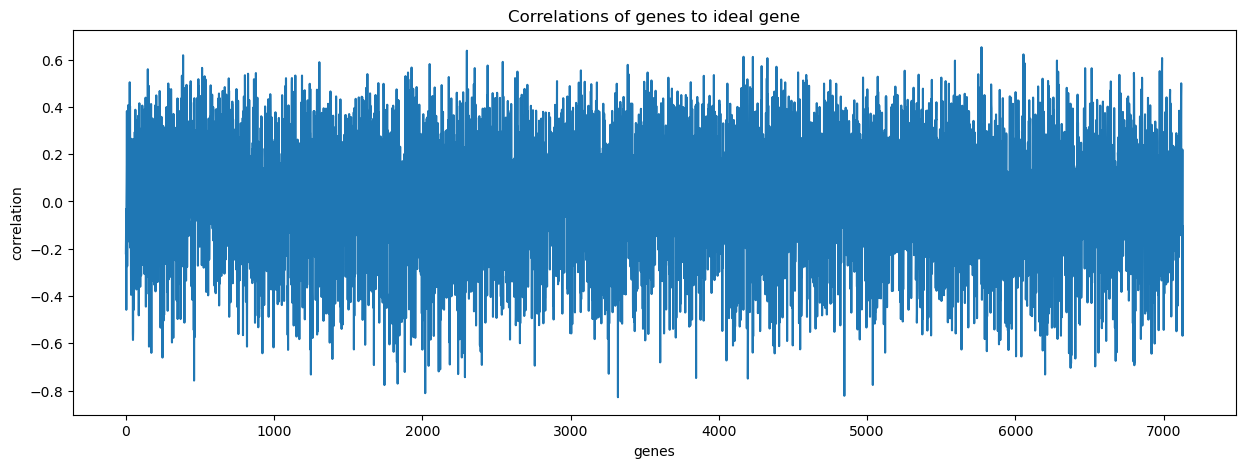

In [227]:
plt.figure(figsize=(15,5))
plt.plot(df)
plt.title('Correlations of genes to ideal gene')
plt.xlabel('genes')
plt.ylabel('correlation')

We choose to keep all genes which have strong postive correlation biger than 0.6:

In [228]:
al = df[df > .6]
print('number of ALL genes: ', al.size)

number of ALL genes:  8


In [229]:
# plt.matshow(X.iloc[:,al.index].astype(float))
# plt.show()

We choose to keep all genes which have strong negative correlation smaller than -0.6:

In [230]:
am = df[df < -.6]
print('number of AML genes :', am.size)

number of AML genes : 76


In [231]:
#plt.matshow(X.iloc[:,am.index].astype(float))
#plt.show()

Build a temp variable containing both genes that have strong correlation with the idealised gene:

In [232]:
temp = al.index.append(am.index).unique()
temp = temp.sort_values()
print('total number of genes: ', temp.size)
print('genes indexes are: ','\n', *temp.values)

total number of genes:  84
genes indexes are:  
 156 172 247 386 460 817 921 996 1094 1246 1248 1393 1538 1614 1673 1744 1778 1806 1816 1828 1833 1881 1882 1923 2000 2019 2042 2110 2120 2185 2241 2266 2274 2287 2300 2388 2393 2401 2758 3257 3319 3604 3846 4051 4095 4166 4195 4228 4229 4327 4365 4376 4406 4498 4548 4846 5038 5121 5636 5771 5807 5889 5953 6004 6040 6054 6184 6199 6200 6361 6372 6375 6377 6404 6538 6560 6676 6683 6796 6802 6805 6918 6939 6989


Plot a matrix of the 84 genes:

Text(0, 0.5, 'Samples')

<Figure size 1500x500 with 0 Axes>

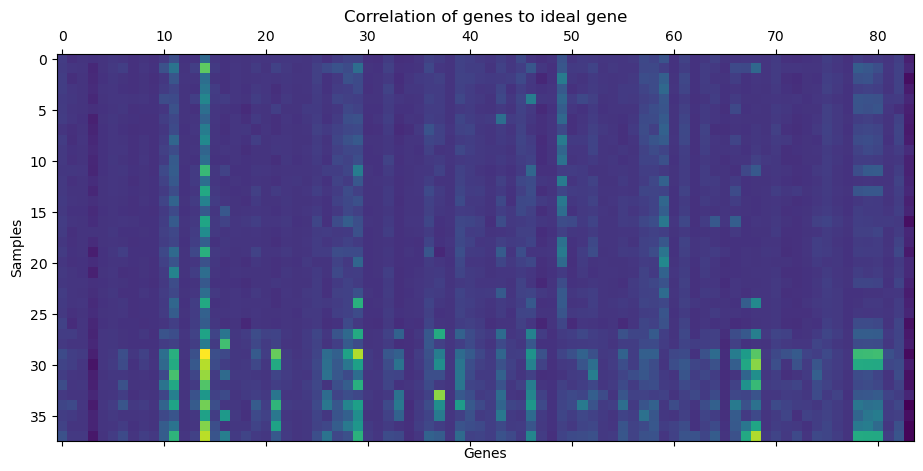

In [233]:
plt.figure(figsize=(15,5))
plt.matshow(X.iloc[:,temp].astype(float))
plt.gca().xaxis.set_label_position('bottom') 
plt.title('Correlation of genes to ideal gene')
plt.xlabel('Genes')
plt.ylabel('Samples')

We will use these 84 genes to build the random forest classifier as it provides the highest score.  
First we will find the number of forest needed in order to obtain the maximal score:

In [234]:
scores_gulup_rfc = []
for i in range(2,200,5):
    rfc = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=2, random_state=0)
    rfc = rfc.fit(X[X.columns[temp]], Y)
    scores_gulup_rfc.append(rfc.score(x[x.columns[temp]], y))

We will plot the scores for a visual representation:

Text(0, 0.5, 'score')

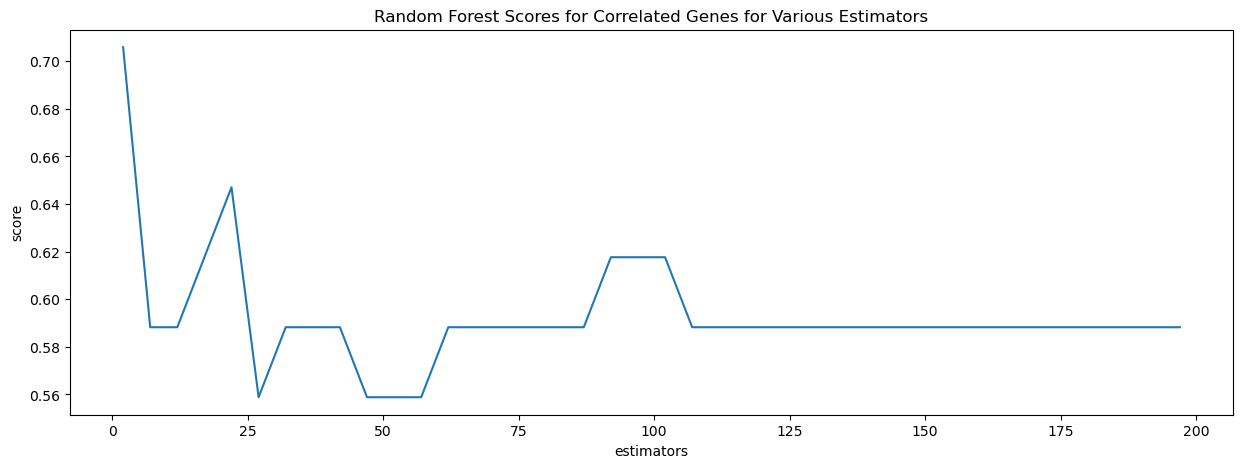

In [235]:
plt.figure(figsize=(15,5))
plt.plot(range(2,200,5), scores_gulup_rfc)
plt.title('Random Forest Scores for Correlated Genes for Various Estimators')
plt.xlabel('estimators')
plt.ylabel('score')

Show the maximum score and the number of trees giving this score:

In [236]:
rfc_gulup_score = np.round(max(scores_gulup_rfc)*100,1)
scores['Golup et al., Random Forest'] = rfc_gulup_score
print('Golup et al. score :', rfc_gulup_score,'%')
print('Number of trees :',range(2,200,5)[np.where(scores_gulup_rfc==max(scores_gulup_rfc))[0][0]])

Golup et al. score : 70.6 %
Number of trees : 2


The number of tree giving us the best score is 2:

We will rebuild the random forest with 2 trees and time it:

In [237]:
max_numb_forests = range(2,200,5)[np.where(scores_gulup_rfc==max(scores_gulup_rfc))[0][0]]

In [238]:
rfc = RandomForestClassifier(n_estimators=max_numb_forests, max_depth=None, min_samples_split=2, random_state=0)

Timing the execution times:

In [239]:
times['Golup et al., Random Forest'] = %timeit -o rfc.fit(X[X.columns[temp]], Y)

8.09 ms ± 207 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 11. USING PCA TO REDUCE DIMENSIONS

In [240]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import timeit
scaler = StandardScaler()

Normalise the data first:

In [241]:
scaler.fit(X)
X_std = scaler.fit_transform(X)
x_std = scaler.fit_transform(x)

In [242]:
pca_tot_scores = []
min_rand_forest = []
ran = range(2,200,5)
timed = []

for p in np.arange(.5, 1, .05): # PCA explains at least p% of the variance
    start = timeit.timeit()
    pca = PCA(p) # find number of components so PCA explains at east p% of the variance
    pca.fit(X_std)
    X_pca = pca.transform(X_std)
    x_pca = pca.transform(x_std)
    
    # Find the scores for 2 to 200, every 5, random forests.
    pca_scores = []
    for i in ran:
        rfc_pca = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=2, random_state=0)
        rfc_pca = rfc_pca.fit(X_pca, Y)
        pca_scores.append(rfc_pca.score(x_pca, y))
    pca_tot_scores.append(max(pca_scores))
    min_rand_forest.append(ran[np.where(pca_scores==max(pca_scores))[0][0]])
    end = timeit.timeit()
    timed.append(end - start)
print(timed)

[-0.0018334100004722131, 6.752599983883556e-05, 3.557299987733131e-05, 0.000881420000041544, -0.0018667160002223682, 5.5870004871394485e-06, 0.001518656999905943, -0.006788012000470189, -0.001014366000163136, -0.002488342999640736]


Text(0.5, 1.0, 'PCA Score in Function of % Variance Explained and Corresponding Number of Trees in Red')

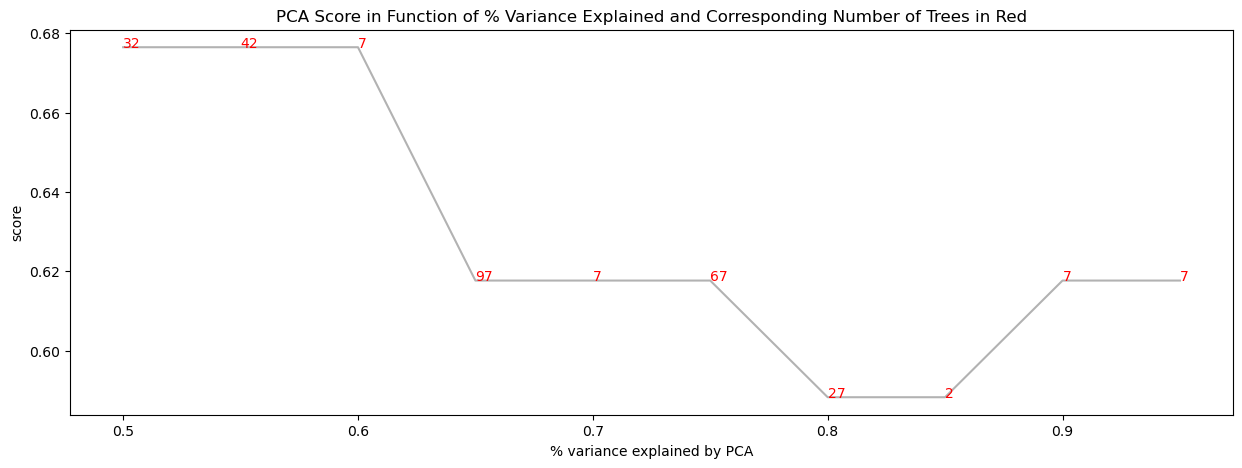

In [243]:
#tot_scores
#min_rand_forest
plt.figure(figsize=(15,5))
plt.plot(np.arange(.5, 1, .05), pca_tot_scores, color='k', alpha=.3)
for i, txt in enumerate(min_rand_forest):
    plt.gca().axes.annotate(txt, (np.arange(.5, 1, .05)[i], pca_tot_scores[i]), color='r')
plt.xlabel('% variance explained by PCA')
plt.ylabel('score')
plt.title('PCA Score in Function of % Variance Explained and Corresponding Number of Trees in Red')

In [244]:
pca = PCA(.6)
pca.fit(X_std)
X_pca = pca.transform(X_std)
x_pca = pca.transform(x_std)

In [245]:
X.shape
X_pca.shape
Y.shape
x.shape
x_pca.shape
y.shape

(34,)

In [246]:
per_var = np.round(pca.explained_variance_ratio_ *100, 1)
print(per_var)

[15.  12.   6.6  4.9  4.6  3.7  3.5  3.3  3.   2.6  2.5]


Text(0.5, 1.0, 'Amount of variance per principal component')

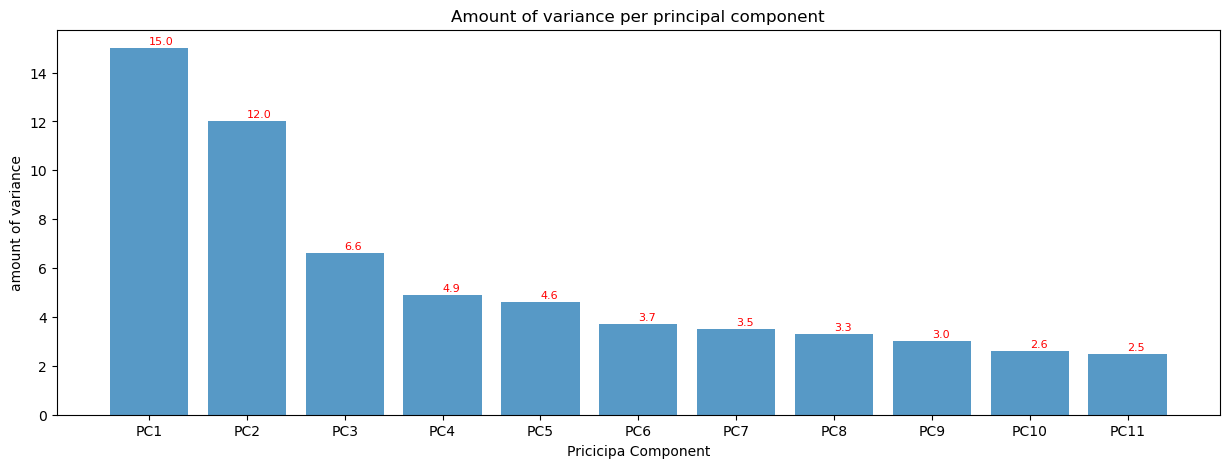

In [247]:
labels = ['PC' + str(x) for x in range(1,X_pca.shape[1]+1)]
plt.figure(figsize=(15,5))
plt.bar(labels, per_var, alpha=0.75)
for i, txt in enumerate(per_var):
    plt.gca().axes.annotate(txt, (labels[i], per_var[i]+.15), color='r', size=8)
plt.xlabel('Pricicipa Component')
plt.ylabel('amount of variance')
plt.title('Amount of variance per principal component')

In [248]:
loading_scores = pd.DataFrame(pca.components_.T, index=X.columns)
loading_scores

,0,1,2,3,4,5,6,7,8,9,10
Gene Accession Number,,,,,,,,,,,
AFFX-BioB-5_at,-0.012974,-0.002176,0.007174,-0.027425,0.002962,-0.003336,-0.004381,-0.002098,-0.015201,0.021156,0.032233
AFFX-BioB-M_at,-0.006485,-0.004862,0.007913,-0.014098,-0.011818,-0.010975,0.005554,-0.017506,-0.022641,0.006072,0.009140
AFFX-BioB-3_at,0.001865,-0.003563,0.001591,-0.002096,-0.004139,0.003339,0.035167,-0.014112,-0.012585,0.007742,-0.004943
AFFX-BioC-5_at,0.008901,0.008036,0.029228,-0.002163,-0.006673,-0.010166,-0.009297,-0.000044,-0.005381,0.001362,0.005573
AFFX-BioC-3_at,-0.019864,0.005340,0.015699,-0.001214,-0.017394,-0.002296,-0.008371,0.009494,-0.003137,-0.001576,0.001160
...,...,...,...,...,...,...,...,...,...,...,...
X83863_at,0.023664,0.000766,0.014341,-0.004626,0.020401,-0.004576,-0.004524,-0.009616,-0.000724,-0.009856,-0.005845
Z17240_at,0.020451,0.006303,-0.012242,0.014994,-0.006163,-0.009519,-0.013225,-0.000374,0.001960,-0.006497,0.006644
L49218_f_at,0.007150,0.015703,-0.007215,-0.011860,-0.007744,-0.005788,-0.009895,-0.009296,0.007952,-0.022662,-0.002860


Compute the top 20 scores for each PCA. Then extrac the coresponding gene index, combine them and remove any duplicates. This will provide all major individual genes from the PCA analysis. 

In [249]:
top_20_genes = []
for component in range(0,X_pca.shape[1]):
    loading_scores = pd.Series(pca.components_[component])
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
    top_20_genes.append(sorted_loading_scores[0:20].index.values)
top_genes = np.stack(top_20_genes, axis=0).flatten()
top_genes = np.unique(top_genes)
top_genes = np.sort(top_genes)

print(top_genes)
top_genes.shape

[   2   14   59  119  175  200  211  225  318  322  338  400  427  451
  466  468  495  588  589  697  731  738  739  796  810  829  920  921
  929  941  950  986  990 1019 1031 1042 1045 1073 1090 1094 1185 1190
 1222 1248 1301 1306 1349 1359 1380 1393 1498 1583 1614 1641 1645 1673
 1710 1713 1724 1759 1772 1801 1882 1896 1993 2005 2017 2020 2042 2155
 2167 2238 2241 2323 2347 2358 2379 2397 2422 2449 2506 2535 2593 2626
 2633 2762 2788 2798 2846 2858 2892 2908 2931 3022 3070 3124 3136 3156
 3168 3207 3221 3243 3256 3257 3290 3354 3420 3422 3506 3543 3548 3560
 3610 3641 3660 3783 3811 3826 3831 3835 3838 3841 3844 3894 3895 3902
 3921 3990 4016 4058 4061 4096 4131 4133 4174 4195 4228 4244 4321 4385
 4483 4524 4526 4528 4545 4547 4548 4607 4634 4636 4691 4833 4846 4847
 4957 4979 4987 5047 5080 5125 5159 5199 5220 5227 5235 5256 5300 5384
 5385 5488 5568 5572 5638 5693 5706 5728 5859 5860 5881 5893 5905 5910
 5935 5972 5990 6077 6136 6138 6144 6147 6160 6167 6201 6250 6290 6337
 6377 

(218,)

There are the 218 most influential genes that are part of the 11 pricnicipal components.

In [250]:
X_top_genes = X[X.columns[top_genes]]
x_top_genes = x[x.columns[top_genes]]
print(X_top_genes.shape)
print(x_top_genes.shape)

(38, 218)
(34, 218)


We will use these 218 genes to build the random forest classifier.
First we will find the number of forest needed in order to obtain the maximal score:

In [251]:
pca_top_scores = []
for i in range(2,200,5):
    rfc = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=2, random_state=0)
    rfc = rfc.fit(X_top_genes, Y)
    pca_top_scores.append(rfc.score(x_top_genes, y))

We will plot the scores for a visual representation:

Text(0.5, 1.0, 'Random Forest Classification Scire of Most Influential Genes For Different Estimators')

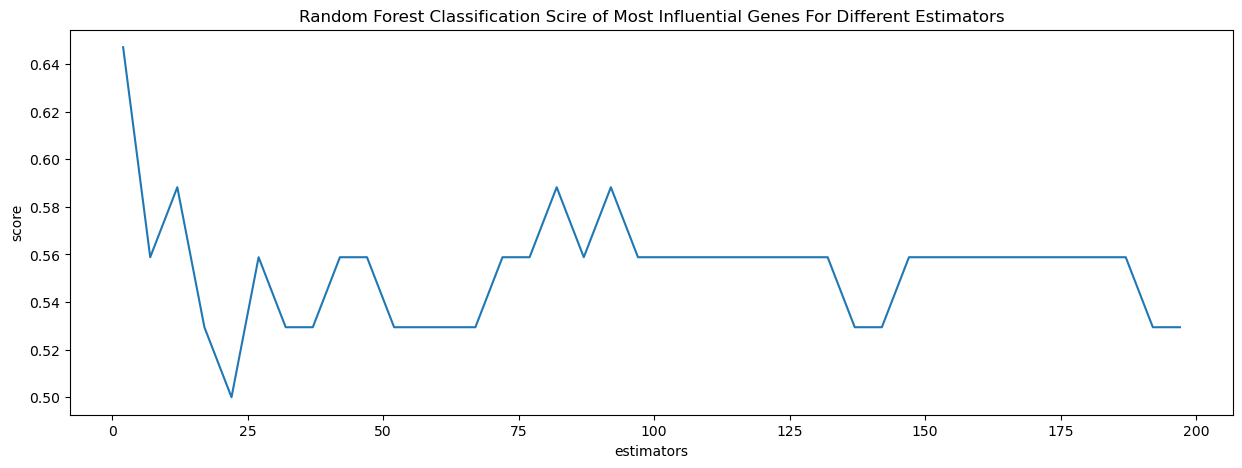

In [252]:
plt.figure(figsize=(15,5))
plt.plot(range(2,200,5), pca_top_scores)
plt.xlabel('estimators')
plt.ylabel('score')
plt.title('Random Forest Classification Scire of Most Influential Genes For Different Estimators')

Show the maximum score and the number of trees giving this score:

In [253]:
score_pca = np.round(max(pca_top_scores)*100,1)
scores['PCA, Random Forest'] = score_pca
print('Using PCA and random forest score :', score_pca,'%')
print('Number of trees :',range(2,200,5)[np.where(pca_top_scores==max(pca_top_scores))[0][0]])

Using PCA and random forest score : 64.7 %
Number of trees : 2


The number of tree giving us the best score is 2:

We will rebuild the random forest with 2 trees and time it:

In [254]:
max_numb_forests = range(2,200,5)[np.where(pca_top_scores==max(pca_top_scores))[0][0]]

In [255]:
rfc = RandomForestClassifier(n_estimators=max_numb_forests, max_depth=None, min_samples_split=2, random_state=0)

Timing the execution times:

In [256]:
times['PCA, Random Forest'] = %timeit -o rfc.fit(X_top_genes, Y)

8.15 ms ± 570 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# 12. USING THE FILTERED DATA FROM 50% TRESHOLD PROPOSED BY MCCLINTICK AND EDENBERG #
#### (2) McClintick JN, Edenberg HJ. Effects of filtering by Present call on analysis of microarray experiments. *BMC Bioinformatics.* 2006;7:49. Published 2006 Jan 31.doi:10.1186/1471-2105-7-49 ####
## PREPARING THE DATA: ##

Transform the categorical values A, M and P into values. (A=0.; M=.51; P=1.)

In [257]:
train2 = train.copy()
quantify_presence(train2, train_cats)

Sum all categorical values along the horizontal axis (axis=1):

In [258]:
genes_index = train2.loc[:,train_cats].sum(axis=1) # it is the sum of all A,M adn P values for each gene

There are N number of catergorical values. We are interested in the values that are Present (P), not at all on values that are abscent (A) and medium on marginal values (M). If for a particular gene, all values are present, all categorical values will be equal to 1, thus the sum will be equal to N, the number of columns. We will set our treshhold to be at least acounting for at least half of the columns: $len(cats)/2$

In [259]:
treshold = len(train_cats)/2  # len(cats) = 39

A histogram sows that a lot of genes have Absent expression and should not be normally conssidered.  
They are on the left of the red treshold line.

Text(0.5, 1.0, 'Histogram of occurances of quantified categorical values')

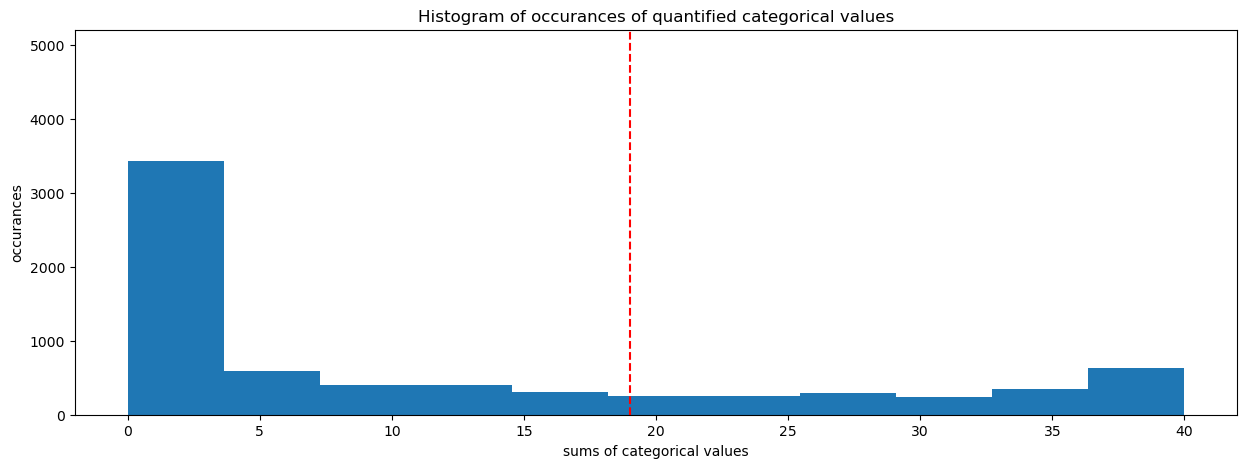

In [260]:
#treshold
#genes_index.describe()
plt.figure(figsize=(15,5))
plt.hist(genes_index, bins=11, range=(0,40))
ax = plt.gca()
ax.axvline(treshold, color='r', linestyle='--')
ax.set_ylim([0,5200])
plt.xlabel('sums of categorical values')
plt.ylabel('occurances')
plt.title('Histogram of occurances of quantified categorical values')
#genes_index

Make all values bellow treshold equal to 0:

In [261]:
genes_index_filtered = [x if x >= treshold else 0 for x in genes_index]

Text(0.5, 1.0, 'Histogram of occurances of quantified categorical values')

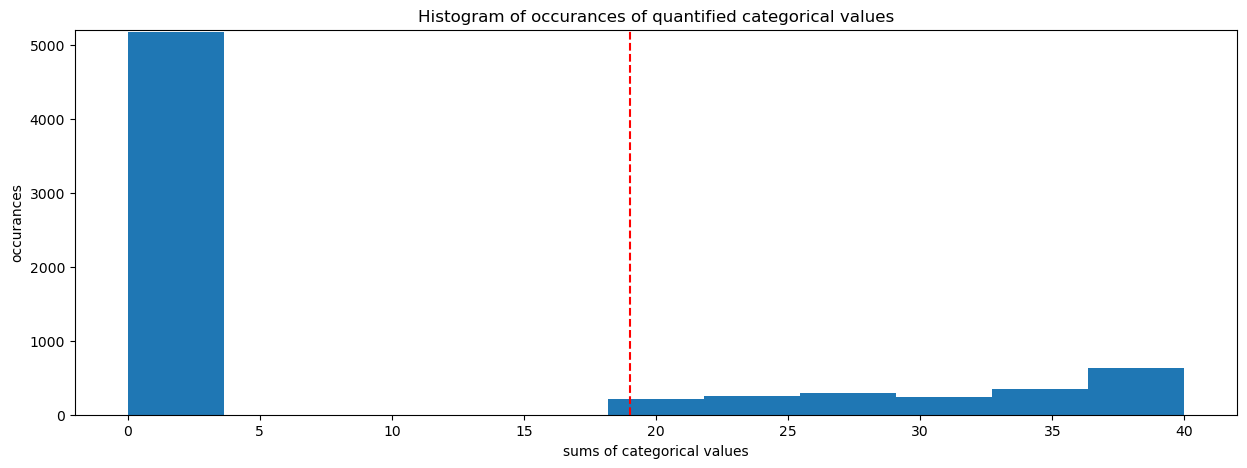

In [262]:
plt.figure(figsize=(15,5))
plt.hist(genes_index_filtered, bins=11, range=(0,40))
ax = plt.gca()
ax.axvline(treshold, color='r', linestyle='--')
ax.set_ylim([0,5200])
plt.xlabel('sums of categorical values')
plt.ylabel('occurances')
plt.title('Histogram of occurances of quantified categorical values')

Transform everything in True/False binary array.  
In True are genes that are retained for the analysis:

In [263]:
genes_index_filtered_binary = [x!=0 for x in genes_index_filtered]
genes_index_filtered_binary = np.array(genes_index_filtered_binary)

Verify that the sizes are maching:

In [264]:
print(train2.shape)
print(genes_index_filtered_binary.shape)

(7129, 78)
(7129,)


Filter the dataframe to keep only the genes that are above the trheshold, i.e. True values:

In [265]:
train2_filtered = train2.iloc[genes_index_filtered_binary,]

Do some visualisations of the dataframe:

In [266]:
# train2_filtered.iloc[:,1]
# train2_filtered[train_conts]
train2_filtered.shape
# train2_filtered

(1965, 78)

Keep only the genes accession number and the genes value reading:

In [267]:
train_filtered = pd.concat([train2_filtered.iloc[:,1], train2_filtered[train_conts]], axis=1).T

Make first row of table name of columns:

In [268]:
train_filtered.columns = train_filtered.iloc[0]

In [269]:
train_filtered.drop(train_filtered.index[0], inplace=True)

In [270]:
train_filtered.index.name = None  # Remove index column name
train_filtered.shape

(38, 1965)

## Statistics: how much A, M and P are there?
### (A = Absent, M = Marginal, P = Present) detection calls of genes.

Divide the data in tree binary tables for A, M and P respectively:

In [271]:
train_cont = train[train_conts].copy() # copy the train data into a new variable
truth_A = pd.DataFrame()
truth_M = pd.DataFrame()
truth_P = pd.DataFrame()

for i in range(0,len(train_conts)): 
    truth_A[train_conts[i]] = train[train_cats].iloc[:,i].str.contains('A')
    truth_M[train_conts[i]] = train[train_cats].iloc[:,i].str.contains('M')
    truth_P[train_conts[i]] = train[train_cats].iloc[:,i].str.contains('P')

In [272]:
#train

In [273]:
#truth_P

In [274]:
#train_cont

Create tree tables containing only the continious values for the genes having A, M or P respectively:

In [275]:
A = train_cont * truth_A
A[A==0] = np.nan
M = train_cont * truth_M
M[M==0] = np.nan
P = train_cont * truth_P
P[P==0] = np.nan

Compute the arithmetic mean for all A, all M and all P respectively:

In [276]:
print(np.nanmean(A))
print(np.nanmean(M))
print(np.nanmean(P))

51.37036502746255
373.019890260631
2054.121944394984


In [277]:
# P 

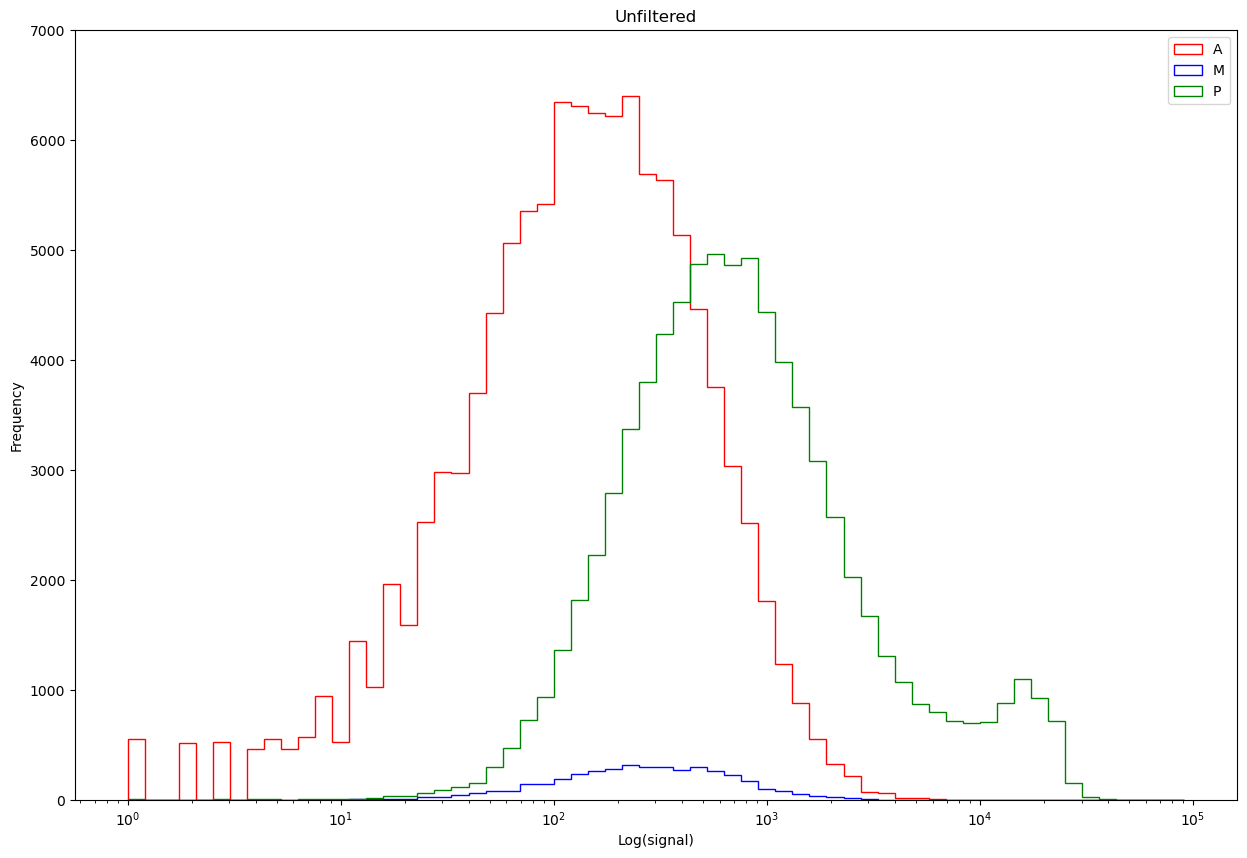

In [278]:
plt.figure(figsize=(15,10))
plt.xscale('log')
bins = 10**(np.arange(0,5,.08))
plt.hist(A.values.flatten(), bins=bins, histtype='step', label='A', color='r')
plt.hist(M.values.flatten(), bins=bins, histtype='step', label='M', color='b')
plt.hist(P.values.flatten(), bins=bins, histtype='step', label='P', color='g')
plt.xlabel('Log(signal)')
plt.ylabel('Frequency')
plt.title('Unfiltered')
axes = plt.gca()
axes.set_ylim([0,7000])
plt.legend()

Flatten the data:

Plot boxplots for A, M and P values:

Text(0.5, 1.0, 'Gene expression valus for Present (P)')

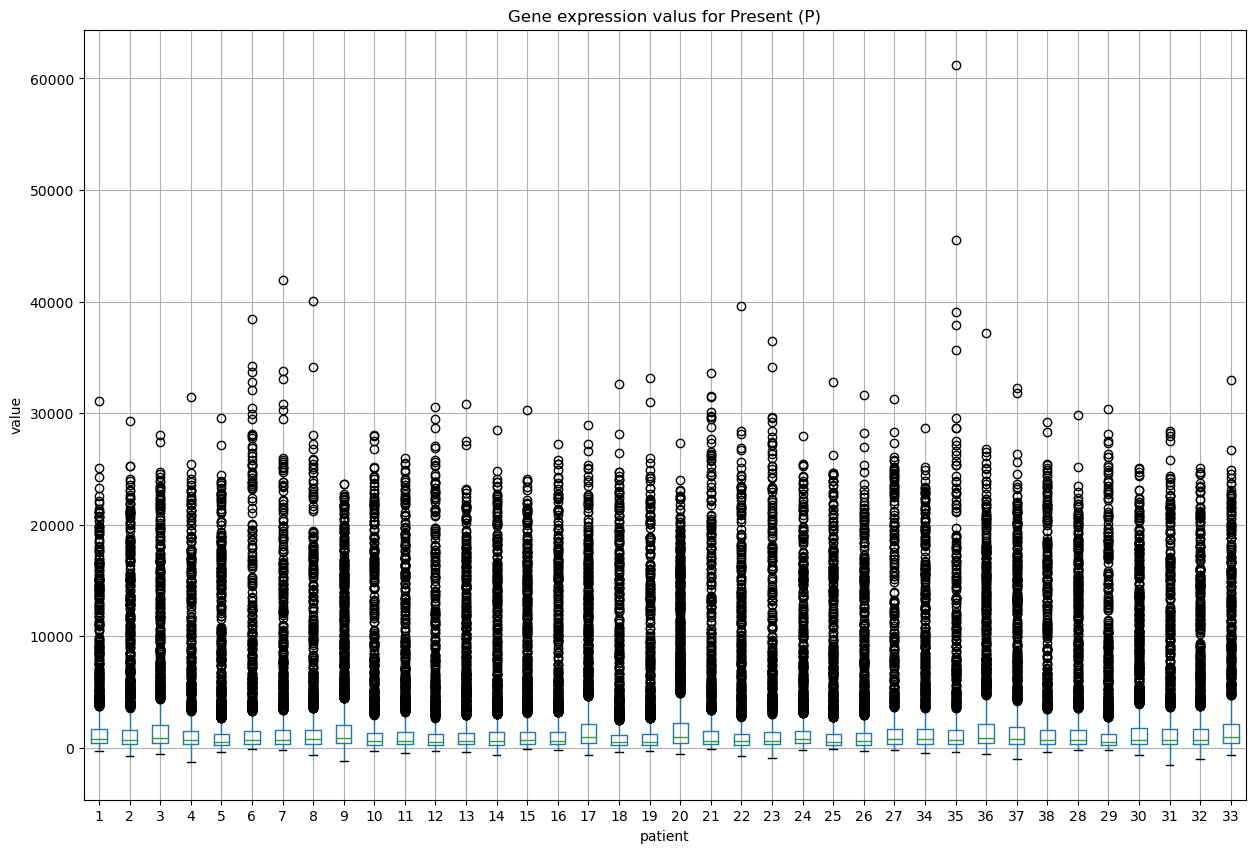

In [279]:
P.boxplot(ax.set_yscale('log'),figsize=(15,10))
plt.xlabel('patient')
plt.ylabel('value')
plt.title('Gene expression valus for Present (P)')

Text(0.5, 1.0, 'Gene expression valus for Absent (A)')

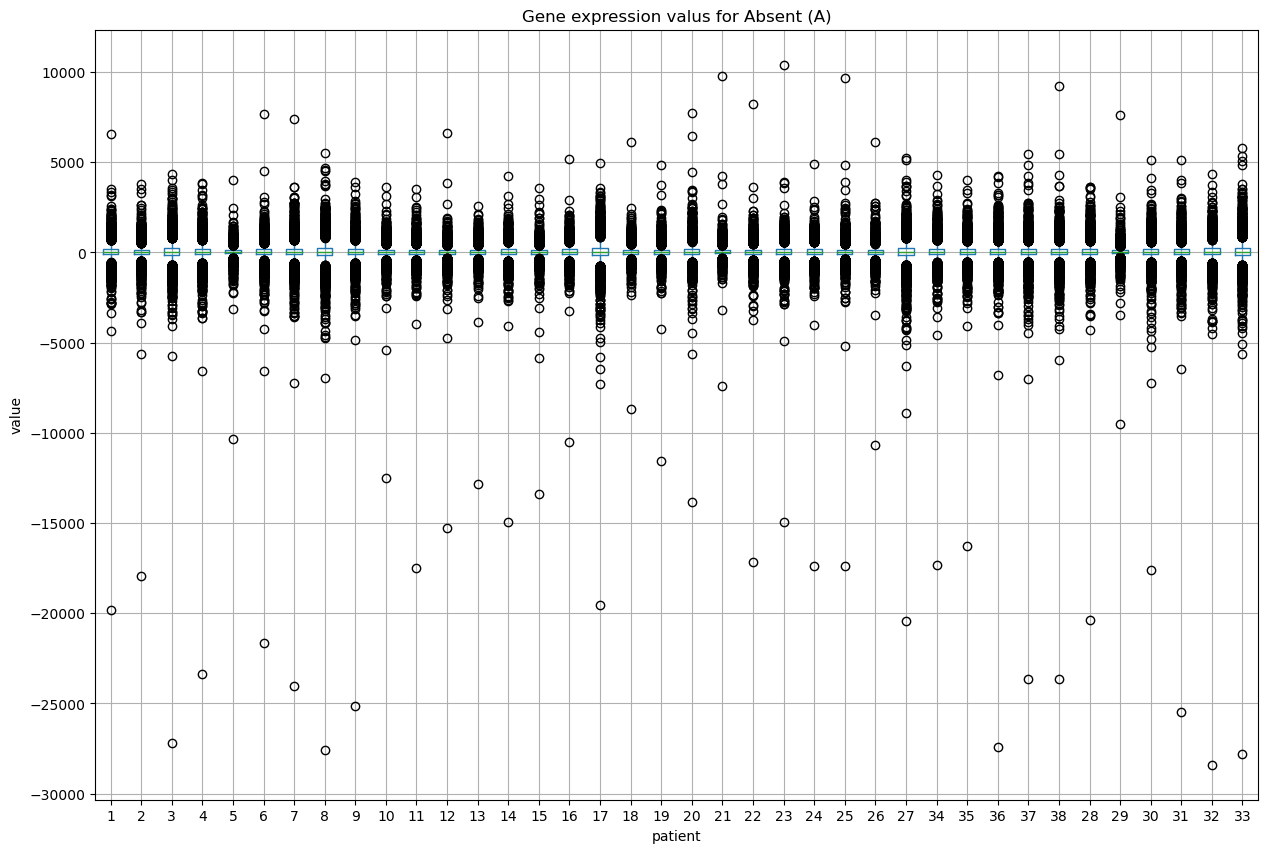

In [280]:
A.boxplot(ax.set_yscale('log'),figsize=(15,10))
plt.xlabel('patient')
plt.ylabel('value')
plt.title('Gene expression valus for Absent (A)')

Text(0.5, 1.0, 'Gene expression valus for Marginal (M)')

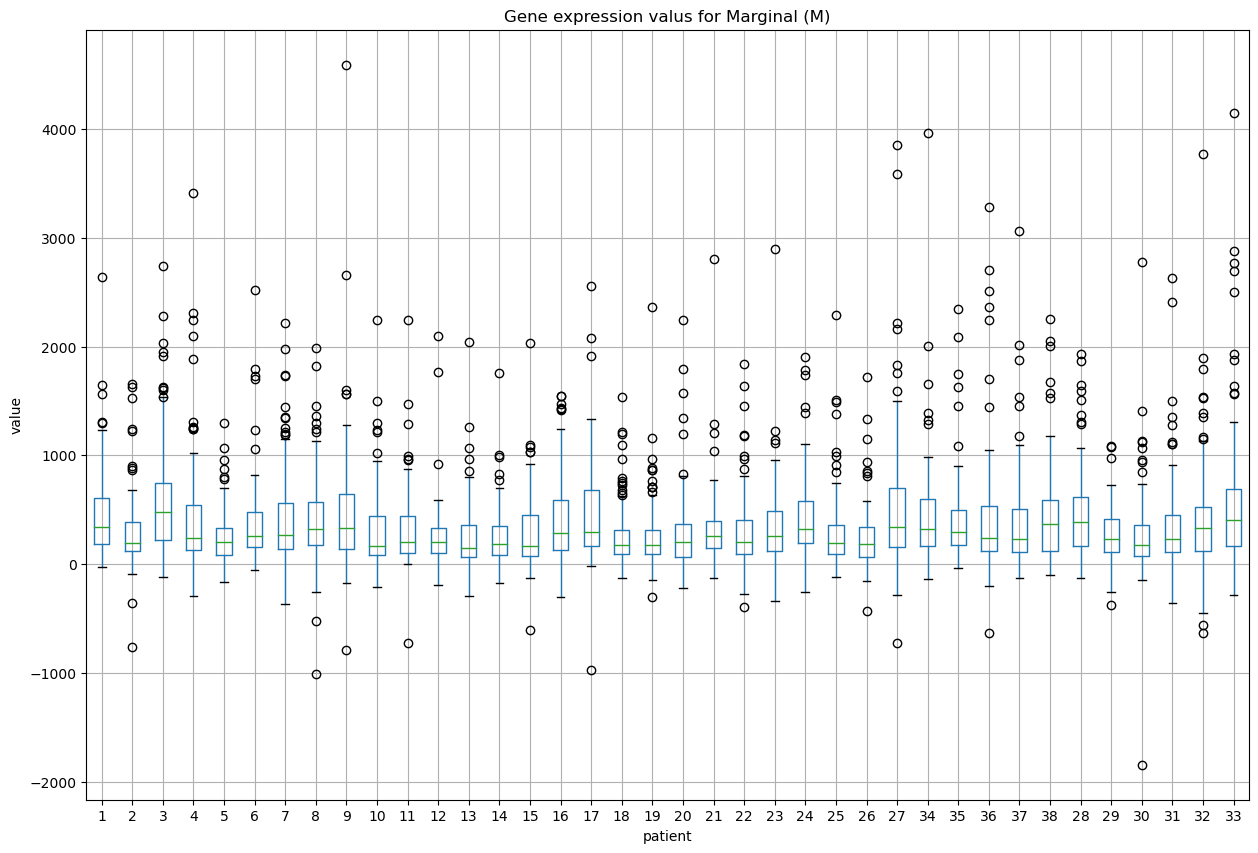

In [281]:
M.boxplot(ax.set_yscale('log'),figsize=(15,10))
plt.xlabel('patient')
plt.ylabel('value')
plt.title('Gene expression valus for Marginal (M)')

## Filter 50% Present detection calls

Create tables containing only the filtered values for A, M and P:

In [282]:
A_filtered = A.iloc[genes_index_filtered_binary,:]
M_filtered = M.iloc[genes_index_filtered_binary,:]
P_filtered = P.iloc[genes_index_filtered_binary,:]

In [283]:
#A_filtered

Plot a histogra of the filtered data:

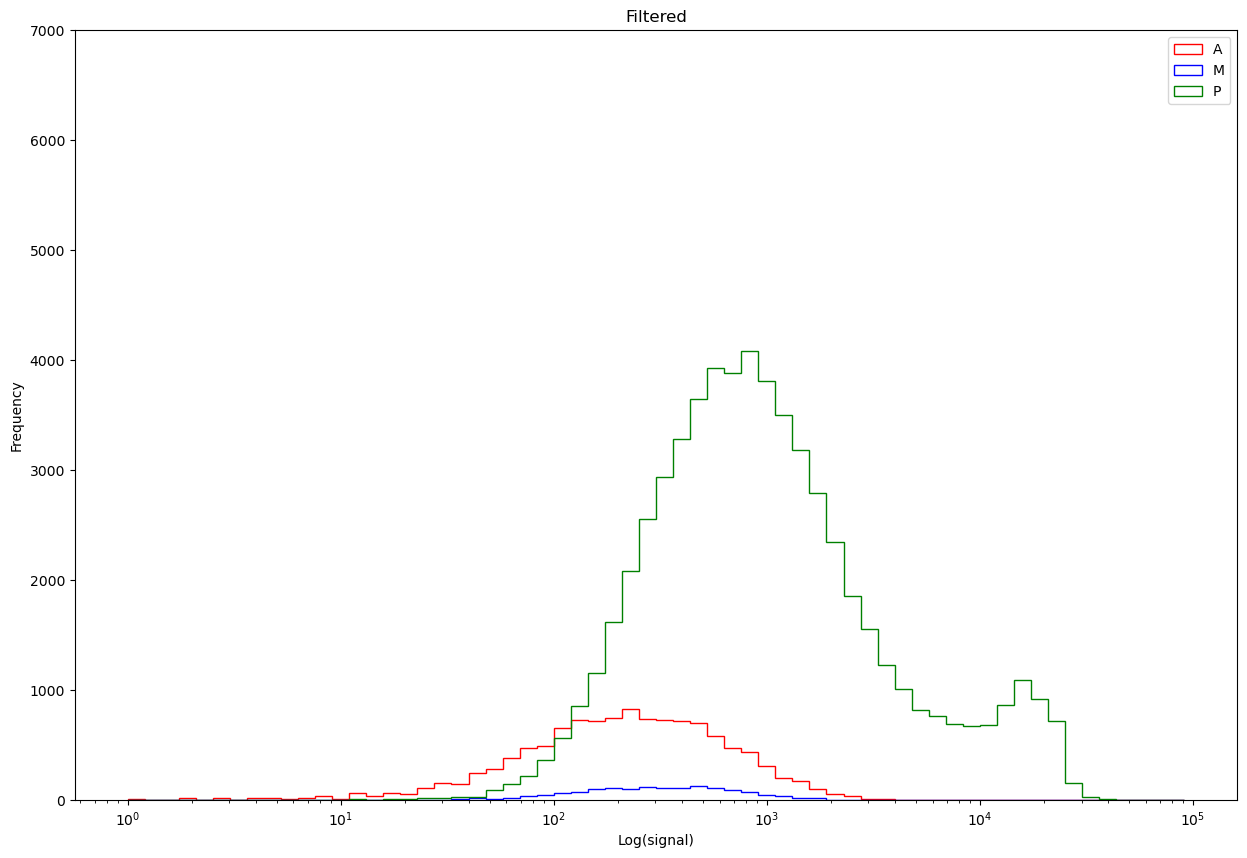

In [284]:
plt.figure(figsize=(15,10))
plt.xscale('log')
bins = 10**(np.arange(0,5,.08))
plt.hist(A_filtered.values.flatten(), bins=bins, histtype='step', label='A', color='r')
plt.hist(M_filtered.values.flatten(), bins=bins, histtype='step', label='M', color='b')
plt.hist(P_filtered.values.flatten(), bins=bins, histtype='step', label='P', color='g')
plt.xlabel('Log(signal)')
plt.ylabel('Frequency')
plt.title('Filtered')
axes = plt.gca()
axes.set_ylim([0,7000])
plt.legend()

We have decreased significantly the amount of abscent detection calls of genes, in order to reduce false positive detection.  
Keeping only 50% of the Positive calls, we obtain a new signal level dataframe.


In [285]:
train2_filtered = train2_filtered.drop(train_cats, axis=1)

In [286]:
print(train2_filtered.shape)
print(train2_filtered.index.values)

(1965, 40)
[  18   37   38 ... 7112 7115 7118]


In [287]:
#train2_filtered

We will use these 1965 genes to train a random forest classifier.

We will build a new training and testing sets with only these 1965 genes.  
The filtered training set:

In [288]:
X_filtered = X[X.columns[train2_filtered.index.values]]
print('Original training size:', X.shape)
print('Filtered training size:', X_filtered.shape)

Original training size: (38, 7129)
Filtered training size: (38, 1965)


The filtered testing set:

In [289]:
x_filtered = x[x.columns[train2_filtered.index.values]]
print('Original testing size:', x.shape)
print('Filtered testing size:', x_filtered.shape)

Original testing size: (34, 7129)
Filtered testing size: (34, 1965)


First we will find the number of forests needed in order to obtain the maximal score:

In [290]:
filtered_scores = []
for i in range(2,200,5):
    rfc = RandomForestClassifier(n_estimators=i, max_depth=None, min_samples_split=2, random_state=0)
    rfc = rfc.fit(X_filtered, Y)
    filtered_scores.append(rfc.score(x_filtered, y))

We will plot the scores for a visual representation:

Text(0.5, 1.0, '50% Present filtered data, Random Forest')

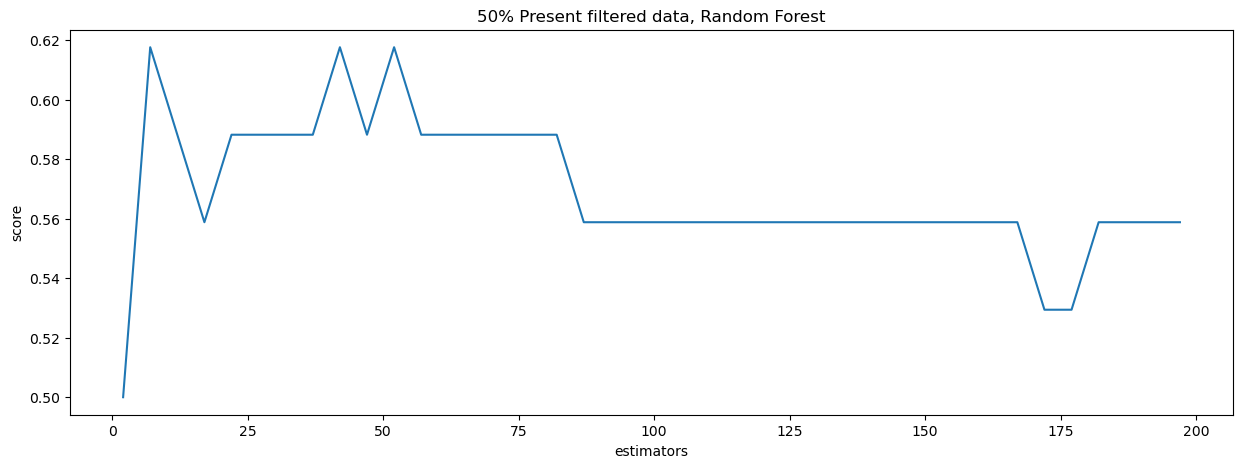

In [291]:
plt.figure(figsize=(15,5))
plt.plot(range(2,200,5), filtered_scores)
plt.xlabel('estimators')
plt.ylabel('score')
plt.title('50% Present filtered data, Random Forest')

Show the maximum score and the number of trees giving this score:

In [292]:
score_filtered_rfc = np.round(max(filtered_scores)*100,1)
scores['50% Present, Random Forest'] = score_filtered_rfc
print('50% Present detection score :', score_filtered_rfc,'%')
print('Number of trees :',range(2,200,5)[np.where(filtered_scores==max(filtered_scores))[0][0]])

50% Present detection score : 61.8 %
Number of trees : 7


The number of tree giving us the best score is 7.   
We will rebuild the random forest with 7 trees and time it:

In [293]:
max_numb_forests = range(2,200,5)[np.where(filtered_scores==max(filtered_scores))[0][0]]

In [294]:
rfc = RandomForestClassifier(n_estimators=max_numb_forests, max_depth=None, min_samples_split=2, random_state=0)

Timing the execution times:

In [295]:
times['50% Present, Random Forest'] = %timeit -o rfc.fit(X_filtered, Y)

32.5 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# 13. Show the scores for all analysis:

In [296]:
scores_temp = scores.copy()
times_temp = times.copy()

In [297]:
scores_temp = pd.DataFrame(list(scores.items()), columns=['Method','Score (%)'])
scores_temp = scores_temp.sort_values('Score (%)', ascending=False)
scores_temp.reset_index(inplace=True, drop=True)
scores_temp

,Method,Score (%)
0,"Golup et al., Random Forest",70.6
1,Random Forest,67.6
2,Extra Tree,67.6
3,kNN,64.7
4,"PCA, Random Forest",64.7
5,Decision Tree,61.8
6,AddaBoost,61.8
7,"50% Present, Random Forest",61.8
8,Logistic,58.8
9,SVM,55.9


In [298]:
times_temp = pd.DataFrame(list(times.items()), columns=['Method','Execution Time'])
times_temp.reset_index(inplace=True, drop=True)
times_temp

,Method,Execution Time
0,SVM time,188 ms ± 14.7 ms per loop (mean ± std. dev. of...
1,Decision Tree,75.8 ms ± 2.03 ms per loop (mean ± std. dev. o...
2,Random Forest,135 ms ± 7.73 ms per loop (mean ± std. dev. of...
3,Extra Tree,137 ms ± 5.53 ms per loop (mean ± std. dev. of...
4,AddaBoost,99.9 ms ± 1.61 ms per loop (mean ± std. dev. o...
5,Logistic,220 ms ± 22.7 ms per loop (mean ± std. dev. of...
6,kNN,54.7 ms ± 1.67 ms per loop (mean ± std. dev. o...
7,KMeans,180 ms ± 27.5 ms per loop (mean ± std. dev. of...
8,"Golup et al., Random Forest",8.09 ms ± 207 µs per loop (mean ± std. dev. of...
9,"PCA, Random Forest",8.15 ms ± 570 µs per loop (mean ± std. dev. of...


In [299]:
results = scores_temp.merge(times_temp, on='Method', sort=True)
results = results.sort_values('Score (%)', ascending=False)
results.reset_index(inplace=True, drop=True)
results

,Method,Score (%),Execution Time
0,"Golup et al., Random Forest",70.6,8.09 ms ± 207 µs per loop (mean ± std. dev. of...
1,Extra Tree,67.6,137 ms ± 5.53 ms per loop (mean ± std. dev. of...
2,Random Forest,67.6,135 ms ± 7.73 ms per loop (mean ± std. dev. of...
3,"PCA, Random Forest",64.7,8.15 ms ± 570 µs per loop (mean ± std. dev. of...
4,kNN,64.7,54.7 ms ± 1.67 ms per loop (mean ± std. dev. o...
5,"50% Present, Random Forest",61.8,32.5 ms ± 3.2 ms per loop (mean ± std. dev. of...
6,AddaBoost,61.8,99.9 ms ± 1.61 ms per loop (mean ± std. dev. o...
7,Decision Tree,61.8,75.8 ms ± 2.03 ms per loop (mean ± std. dev. o...
8,Logistic,58.8,220 ms ± 22.7 ms per loop (mean ± std. dev. of...
9,KMeans,55.9,180 ms ± 27.5 ms per loop (mean ± std. dev. of...


In [300]:
results.to_clipboard()

***
<h1><center> END OF DOCUMENT</center></h1>